## Data cleaning

In [6]:
#preamble
import pandas as pd
import json
import requests
import numpy as np
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
sns.set()
%matplotlib inline

In [4292]:
def get_ipeds(path):
    '''
    This function fetches IPEDS data from the Urban Institute API.
    '''
    fip_code = 1
    master_df = pd.DataFrame()
    print("[IPEDS] Fetching:", path)
    fip_codes = [ 1,  2,  4,  5,  6,  8,  9, 10, 
                 11, 12, 13, 15, 16, 17, 18, 19, 
                 20, 21, 22, 23, 24, 25, 26, 27, 
                 28, 29, 30, 31, 32, 33, 34, 35, 
                 36, 37, 38, 39, 40, 41, 42, 44, 
                 45, 46, 47, 48, 49, 50, 51, 53, 
                 54, 55, 56] # 51 US states
    for fips in fip_codes: #loops over 51 states
        url = "https://educationdata.urban.org/api/v1/college-university/ipeds/" + path + "/2016/?fips=" + str(fips)
        param = ""
        if path == 'admissions-enrollment':
            param = "&sex=1" # male first, then female
        if path == 'enrollment-full-time-equivalent':
            param = "&level_of_study=1" #only undergrads
        if path == 'fall-retention':
            param = '&ftpt=1' #only full time students
        if path == 'outcome-measures':
            url = "https://educationdata.urban.org/api/v1/college-university/ipeds/" + path + "/2016/?fips=" + str(fips)
            param = '&ftpt=1&class_level=99&fed_aid_type=1'
        if path == 'fall-enrollment':
            url = "https://educationdata.urban.org/api/v1/college-university/ipeds/fall-enrollment/2016/undergraduate/race/sex/?fips=" + str(fips)
            param = '&ftpt=1&sex=99&class_level=99&degree_seeking=1&race=99' 
        url = url + param    
        response = requests.get(url)

        # check the HTTP response code
        response = requests.request('GET', url)

        # PARSE
        colleges = response.json()

        # TRANSFORM
        data = colleges["results"]

        # STORE
        df = pd.DataFrame.from_dict(data)
#==============================================================================================================                  
        if path == 'admissions-enrollment':
            df = df.rename(columns={"number_applied": "male_number_applied",
                                    "number_admitted": "male_number_admitted",
                                    "number_enrolled_ft": "male_enrolled_ft",
                                    "number_enrolled_pt": "male_enrolled_pt",
                                    "number_enrolled_total": "male_enrolled_total"})
            #df = df.drop(['sex'], axis = 1)
            param = "&sex=2"
            url = url + param    
            response = requests.get(url)

            # check the HTTP response code
            response = requests.request('GET', url)

            # PARSE
            colleges = response.json()

            # TRANSFORM
            data = colleges["results"]

            # STORE
            df1 = pd.DataFrame.from_dict(data)
            df1 = df1.rename(columns={"number_applied": "female_number_applied",
                                     "number_admitted": "female_number_admitted",
                                     "number_enrolled_ft": "female_enrolled_ft",
                                     "number_enrolled_pt": "female_enrolled_pt",
                                     "number_enrolled_total": "female_enrolled_total"})
            #df1 = df1.drop(['sex'], axis = 1)
            df = pd.merge(left=df, right=df1, on = ["unitid", "fips", "year"])
    #==============================================================================================================                      
        if path == 'outcome-measures':
            df = df.rename(columns={"completion_rate_6yr": "pell_completion_rate_6yr",
                                    "completion_rate_8yr": "pell_completion_rate_8yr",
                                    "completion_rate_4yr": "pell_completion_rate_4yr"})

            param = "&ftpt=1&class_level=99&fed_aid_type=99"
            url = url + param    
            response = requests.get(url)

            # check the HTTP response code
            response = requests.request('GET', url)

            # PARSE
            colleges = response.json()

            # TRANSFORM
            data = colleges["results"]

            # STORE
            df1 = pd.DataFrame.from_dict(data)
            df = pd.merge(left=df, right=df1, on = ["unitid", "fips", "year"])
    #==============================================================================================================          
        if path == 'fall-enrollment':
            df = df.rename(columns={"enrollment_fall": "total_enrollment"})
            
            #white    
            param = "'&ftpt=1&sex=99&class_level=99&degree_seeking=1&race=1"
            url = url + param    
            response = requests.get(url)
            response = requests.request('GET', url)
            colleges = response.json()
            data = colleges["results"]
            df1 = pd.DataFrame.from_dict(data)
            df1 = df1.rename(columns={"enrollment_fall": "white_enrollment"})
            df = pd.merge(left=df, right=df1, on = ["unitid", "fips", "year"])

            #black    
            param = "'&ftpt=1&sex=99&class_level=99&degree_seeking=1&race=2"
            url = url + param    
            response = requests.get(url)
            response = requests.request('GET', url)
            colleges = response.json()
            data = colleges["results"]
            df1 = pd.DataFrame.from_dict(data)
            df1 = df1.rename(columns={"enrollment_fall": "black_enrollment"})
            df = pd.merge(left=df, right=df1, on = ["unitid", "fips", "year"])

            #hispanic    
            param = "'&ftpt=1&sex=99&class_level=99&degree_seeking=1&race=3"
            url = url + param    
            response = requests.get(url)
            response = requests.request('GET', url)
            colleges = response.json()
            data = colleges["results"]
            df1 = pd.DataFrame.from_dict(data)
            df1 = df1.rename(columns={"enrollment_fall": "hispanic_enrollment"})
            df = pd.merge(left=df, right=df1, on = ["unitid", "fips", "year"])

            #asian    
            param = "'&ftpt=1&sex=99&class_level=99&degree_seeking=1&race=4"
            url = url + param    
            response = requests.get(url)
            response = requests.request('GET', url)
            colleges = response.json()
            data = colleges["results"]
            df1 = pd.DataFrame.from_dict(data)
            df1 = df1.rename(columns={"enrollment_fall": "asian_enrollment"})
            df = pd.merge(left=df, right=df1, on = ["unitid", "fips", "year"])
        master_df = master_df.append(df)
    return master_df

In [22]:
def get_scorecard(path):
    '''
    This function fetches College Scorecard data from the Urban Institute.
    '''
    master_df = pd.DataFrame()
    print("[Scorecard] Fetching:", path)
    fip_codes = [ 1,  2,  4,  5,  6,  8,  9, 10, 
                 11, 12, 13, 15, 16, 17, 18, 19, 
                 20, 21, 22, 23, 24, 25, 26, 27, 
                 28, 29, 30, 31, 32, 33, 34, 35, 
                 36, 37, 38, 39, 40, 41, 42, 44, 
                 45, 46, 47, 48, 49, 50, 51, 53, 
                 54, 55, 56] # 51 US states
    for fips in fip_codes:
        url = "https://educationdata.urban.org/api/v1/college-university/scorecard/" + path + "/2016/?fips=" + str(fips)
        if path == 'student-characteristics':
            url = "https://educationdata.urban.org/api/v1/college-university/scorecard/" + path + "/2016/aid-applicants/?fips=" + str(fips)        
        response = requests.get(url)

        # check the HTTP response code
        response = requests.request('GET', url)

        # PARSE
        colleges = response.json()

        # TRANSFORM
        data = colleges["results"]

        # STORE
        df = pd.DataFrame.from_dict(data)
        master_df = master_df.append(df)
    return master_df

In [23]:
def get_census():
    '''
    This function fetches Census data from the Urban Institute.
    '''
    master_df = pd.DataFrame()
    fip_codes = [ 1,  2,  4,  5,  6,  8,  9, 10, 
                 11, 12, 13, 15, 16, 17, 18, 19, 
                 20, 21, 22, 23, 24, 25, 26, 27, 
                 28, 29, 30, 31, 32, 33, 34, 35, 
                 36, 37, 38, 39, 40, 41, 42, 44, 
                 45, 46, 47, 48, 49, 50, 51, 53, 
                 54, 55, 56] # 51 US states
    for fips in fip_codes:
        url = "https://educationdata.urban.org/api/v1/college-university/nhgis/census-2010/2017/?fips=" + str(fips)
        param = ""
        url = url + param    
        
        response = requests.get(url)

        # check the HTTP response code
        response = requests.request('GET', url)

        # PARSE
        colleges = response.json()

        # TRANSFORM
        data = colleges["results"]

        # STORE
        df = pd.DataFrame.from_dict(data)
        master_df = master_df.append(df)
    return master_df

In [12]:
#Call functions to get data: this process takes a while
directory = get_ipeds("directory")
institutional_characteristics = get_ipeds('institutional-characteristics')  
admissions_enrollment = get_ipeds('admissions-enrollment') 
admissions_requirements = get_ipeds('admissions-requirements')
fall_enrollment = get_ipeds('fall-enrollment')
fall_retention = get_ipeds('fall-retention')
finance = get_ipeds('finance')
student_faculty_ratio = get_ipeds('student-faculty-ratio')
outcome_measures = get_ipeds('outcome-measures')
scorecard_institutional = get_scorecard('institutional-characteristics')
scorecard_student = get_scorecard('student-characteristics')
census = get_census()

[IPEDS] Fetching: directory


In [28]:
#merge different datasets together
colleges = pd.merge(left = directory, right = institutional_characteristics, how = "left", on = ["unitid"])
colleges = pd.merge(left = colleges, right = admissions_enrollment, how = "left", on = ["unitid"])
colleges = pd.merge(left = colleges, right = admissions_requirements, how = "left", on = ["unitid"])
colleges = pd.merge(left = colleges, right = fall_enrollment, how = "left", on = ["unitid"])
colleges = pd.merge(left = colleges, right = fall_retention, how = "left", on = ["unitid"])
colleges = pd.merge(left = colleges, right = finance, how = "left", on = ["unitid"])
colleges = pd.merge(left = colleges, right = student_faculty_ratio, how = "left", on = ["unitid"])
colleges = pd.merge(left = colleges, right = outcome_measures, how = "left", on = ["unitid"])
colleges = pd.merge(left = colleges, right = scorecard_institutional, how = "left", on = ["unitid"])
colleges = pd.merge(left = colleges, right = scorecard_student, how = "left", on = ["unitid"])
colleges = pd.merge(left = colleges, right = census, how = "left", on = ["unitid"])
colleges = colleges.drop_duplicates()

#save to CSV so API does not need to constantly be re-run
colleges.to_csv("colleges.csv", index = False) 

In [4334]:
colleges = pd.read_csv("colleges.csv")
    
#keep relevant variables    
dta = colleges[[
    "unitid",
    "inst_name_x",
    "state_abbr_x",
    "census_region",
    "inst_control",
    "sector",
    "institution_level",
    "hbcu",
    "degree_granting",
    "cc_basic_2015",
    "masters_offered",
    "male_number_applied",
    "male_number_admitted",
    "male_enrolled_total",
    "female_number_applied",
    "female_number_admitted",
    "female_enrolled_total",
    "reqt_test_scores",
    "sat_crit_read_25_pctl",
    "sat_crit_read_75_pctl",
    "sat_math_25_pctl",
    "sat_math_75_pctl",
    "act_composite_25_pctl",
    "act_composite_75_pctl",
    "total_enrollment",
    "white_enrollment",
    "black_enrollment",
    "hispanic_enrollment",
    "asian_enrollment",
    "retention_rate",
    "endowment_end",
    "est_fte",
    "member_ncaa",
    "student_faculty_ratio",
    "pell_completion_rate_6yr",
    "completion_rate_6yr",
    "menonly",
    "womenonly",
    "lowincome_pct",
    "highincome_pct",
    "faminc_mean",
    "reqt_hs_diploma",
    "female_pct",
    "open_admissions_policy",
    "longitude_x", "latitude_x",
    "census_division"]]

dta = dta[dta.institution_level == 4] #only 4-year schools
dta = dta[dta.degree_granting == 1] # only degree-granting
dta = dta[(dta.sector == 1) | (dta.sector == 2)] #only public and private 4-year schools
dta = dta[dta['reqt_test_scores'].notna()] #drop schools that have test-optional as missing
dta = dta[dta.cc_basic_2015 > 0] #must have carnegie classification

#read in supplemental ipeds dataset
supplemental_ipeds = pd.read_csv("supplemental_ipeds.csv")
supplemental_ipeds.columns = map(str.lower, supplemental_ipeds.columns)
dta = pd.merge(dta, supplemental_ipeds, how = "left", on = ["unitid"])

#read in barrons dataset
barrons = pd.read_csv("barrons2004.csv")
dta = pd.merge(dta, barrons, how = "left", on = ["unitid"])


## replace -3.0000 with NA
dta['lowincome_pct'] = np.where((dta.lowincome_pct < 0),np.nan,dta.lowincome_pct)
dta['faminc_mean'] = np.where((dta.faminc_mean < 0),np.nan,dta.faminc_mean)
dta['female_pct'] = np.where((dta.female_pct < 0),np.nan,dta.female_pct)

# generate new variables
dta['test_optional'] = np.where((dta.reqt_test_scores == 2) | (dta.reqt_test_scores == 3) | (dta.reqt_test_scores == 0),1,0)
dta['doctoral'] = np.where((dta.cc_basic_2015 == 15) | (dta.cc_basic_2015 == 16) | (dta.cc_basic_2015 == 17),1,0)
dta['masters'] = np.where((dta.cc_basic_2015 == 18) | (dta.cc_basic_2015 == 19) | (dta.cc_basic_2015 == 20),1,0)
dta['baccalaureate'] = np.where((dta.cc_basic_2015 == 20) | (dta.cc_basic_2015 == 21),1,0)
dta['lib_arts'] = np.where((dta.cc_basic_2015 == 20),1,0)

dta["perc_white"] = dta.white_enrollment/dta.total_enrollment
dta["perc_asian"] = dta.asian_enrollment/dta.total_enrollment
dta["perc_black"] = dta.black_enrollment/dta.total_enrollment
dta["perc_hisp"] = dta.hispanic_enrollment/dta.total_enrollment

dta["perc_minority"] = 1 - (dta.perc_white) - (dta.perc_asian)
dta["private"] = np.where((dta.inst_control != 1),1,0)
dta["adm_rate"] = (dta.male_number_admitted + dta.female_number_admitted)/(dta.male_number_applied + dta.female_number_applied)
dta["yield_rate"] = (dta.male_enrolled_total + dta.female_enrolled_total)/(dta.male_number_admitted + dta.female_number_admitted)
dta["enrolled_total"] = (dta.male_enrolled_total + dta.female_enrolled_total)
dta["admitted_total"] = (dta.male_number_admitted + dta.female_number_admitted)
dta["applied_total"] = (dta.male_number_applied + dta.female_number_applied)

#drop irrelevant variables
dta = dta.drop(['inst_control'], axis = 1)
dta = dta.drop(['sector'], axis = 1)
dta = dta.drop(['degree_granting'], axis = 1)
dta = dta.drop(['institution name'], axis = 1)

#keep only schools that have barrons data
dta = dta[dta['barrons2004'].notna()]

#rename some variables
dta = dta.rename(columns={"cinson (drvic2017)": "coa_in", "cotson (drvic2017)": "coa_out",
                          "inst_name_x": "name", "state_abbr_x": "state"})

#convert census region to dummies
census = pd.get_dummies(dta.census_region)
census = census.rename(columns={
    1: "Northeast",
    2: "Midwest",
    3: "South",
    4: "West"})

dta = pd.concat([dta, census], axis=1)
dta = dta.drop('census_region', axis = 1)

#convert census division to dummies
census_division = pd.get_dummies(dta.census_division)
census_division = census_division.rename(columns={
    1: "New England",
    2: "Middle Atlantic",
    3: "East north central",
    4: "West north central",
    5: "South Atlantic",
    6: "East south central",
    7: "West south central",
    8: "Mountain",
    9: "Pacific",
})
dta = pd.concat([dta, census_division], axis=1)
dta = dta.drop('census_division', axis = 1)

#convert barrons to dummies
barrons = pd.get_dummies(dta.barrons2004)
barrons = barrons.rename(columns={
    2: "Less competitive",
    3: "Competitive",
    4: "Very competitive",
    5: "Highly competitive",
    6: "Most competitive",
})

dta = pd.concat([dta, barrons], axis=1)

#save final CSV with subset data
dta.to_csv("dta_subset.csv", index = False)

/Users/adamhearn/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (24,577,605,606,608,609) have mixed types.Specify dtype option on import or set low_memory=False.



year_x
unitid
inst_name_x
address_x
state_abbr_x
zip_x
phone_number
city_x
county_name_x
offering_highest_level
region
inst_control
institution_level
sector
fips_x
chief_admin_name
chief_admin_title
hbcu
primarily_postsecondary
hospital
medical_degree
tribal_college
ein
urban_centric_locale
opeid_x
offering_highest_degree
currently_active_ipeds
date_closed
duns
title_iv_indicator
offering_undergrad
offering_grad
inst_status
newid
year_deleted
url_school
degree_granting
open_public
postsec_public_active
postsec_public_active_title_iv
inst_system_flag
inst_system_name
reporting_method
inst_category
land_grant
inst_size
inst_alias
url_fin_aid
url_application
cbsa_x
cbsa_type_x
csa_x
necta
comparison_group
longitude_x
latitude_x
county_fips_x
congress_district_id
cc_basic_2010
cc_instruc_undergrad_2010
cc_instruc_grad_2010
cc_undergrad_2010
cc_enroll_2010
cc_size_setting_2010
cc_basic_2000
url_netprice
comparison_group_custom
url_veterans
url_athletes
cc_basic_2015
cc_instruc_undergrad_201

# Modeling

In [1029]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz
import sklearn
import random
from sklearn import tree, preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve, train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, balanced_accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score

## Feature importances

In [1080]:
# read data
dta = pd.read_csv("dta_subset.csv")


#Change private/public control here
dta = dta[dta["private"] == 1]

#Change Barron's classification here
dta = dta[(dta["Less competitive"] == 1)]


#enter feature variables here
dta_names = dta[[
    'name',
    'student_faculty_ratio',
    'completion_rate_6yr', 
    'lowincome_pct', 'retention_rate', 
    'adm_rate', 
    'perc_minority',
    'total_enrollment',
    'yield_rate', 
    'test_optional', 
    'female_pct', 
    'doctoral',  
    'lib_arts',
    'masters', 
    #'private', 
    #'barrons2004',
    #"New England", "Middle Atlantic", "East north central", "West north central", "South Atlantic", "East south central" , "West south central", "Mountain", "Pacific", 
    #"Less competitive","Competitive","Very competitive","Highly competitive","Most competitive",
    ]]

#rename some columns
dta_names = dta_names.rename(columns={
    "student_faculty_ratio": "Student-faculty ratio", 
    "completion_rate_6yr": "6-year completion rate",
    "lowincome_pct": "Pct. low income",
    "retention_rate": "Retention rate",
    "adm_rate": "Admission rate",
    "perc_minority": "Pct. minority",
    "total_enrollment": "Full-time enrollment",
    "yield_rate": "Yield rate",
    "test_optional": "test_optional",
    "female_pct": "Pct. female",
    "doctoral": "Doctoral inst.",
    "lib_arts": "Liberal-arts inst.",
    "masters": "Masters inst.",
    "private": "Private inst."
})


dta_names = dta_names.dropna()

#drop name from df
dta = dta_names.drop(['name'], axis = 1)


In [1081]:
#generate test-required summary stats
test_required = dta[dta.test_optional == 0]
test_required.describe().T[["count", "mean", "std", "min", "max"]]

,count,mean,std,min,max
Student-faculty ratio,63.0,12.761905,2.241214,8.000000,17.000000
6-year completion rate,63.0,0.502857,0.125279,0.110000,0.720000
Pct. low income,63.0,0.367051,0.103100,0.159857,0.674194
Retention rate,63.0,0.696190,0.111159,0.400000,0.940000
Admission rate,63.0,0.669766,0.173083,0.318024,0.965748
Pct. minority,63.0,0.421920,0.238194,0.087284,0.994078
Full-time enrollment,63.0,1517.285714,979.666277,389.000000,5553.000000
Yield rate,63.0,0.229539,0.092833,0.103406,0.475138
test_optional,63.0,0.000000,0.000000,0.000000,0.000000
Pct. female,63.0,0.606629,0.119124,0.346199,0.936000


In [1082]:
#test-optional summary stats
opt_schools = dta[dta.test_optional == 1]
opt_schools.describe().T[["count", "mean", "std", "min", "max"]]

,count,mean,std,min,max
Student-faculty ratio,32.0,13.562500,2.770088,9.000000,19.000000
6-year completion rate,32.0,0.503437,0.097107,0.280000,0.700000
Pct. low income,32.0,0.362403,0.144271,0.126093,0.694974
Retention rate,32.0,0.690000,0.087437,0.500000,0.820000
Admission rate,32.0,0.775075,0.142594,0.439246,0.995876
Pct. minority,32.0,0.452567,0.246031,0.155979,0.986270
Full-time enrollment,32.0,1922.625000,1799.711388,280.000000,7598.000000
Yield rate,32.0,0.205681,0.093413,0.052310,0.499429
test_optional,32.0,1.000000,0.000000,1.000000,1.000000
Pct. female,32.0,0.614131,0.125502,0.266243,0.978997


## Decision tree

In [1086]:
# feature matrix and target array
Xcollege = dta.drop(['test_optional'], axis = 1)
ycollege = dta['test_optional']

# How many test-optional colleges?
print('All schools:', len(ycollege))
print('Test-optional:', len(ycollege[ycollege==1]))
print("(" + str(round(len(ycollege[ycollege==1])/len(ycollege)*100,2)) + "%)")

All schools: 95
Test-optional: 32
(33.68%)


### Fit a decision tree classifier using the entire set of observations and evaluate the performance of the model using five-fold cross-validation

In [1087]:
# fit model
model = tree.DecisionTreeClassifier(random_state = 3)
model.fit(Xcollege, ycollege)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=3, splitter='best')

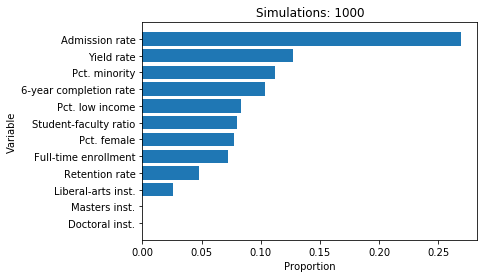

                  Variable  Importance
9           Doctoral inst.    0.000000
11           Masters inst.    0.000000
10      Liberal-arts inst.    0.026127
3           Retention rate    0.048092
6     Full-time enrollment    0.072359
8              Pct. female    0.077256
0    Student-faculty ratio    0.079910
2          Pct. low income    0.083267
1   6-year completion rate    0.103838
5            Pct. minority    0.112308
7               Yield rate    0.127432
4           Admission rate    0.269411


In [1088]:
#create feature importance simulation
x = 1
feats = pd.DataFrame({'Variable': Xcollege.columns})

sims = 1000

while x < sims:
    model = tree.DecisionTreeClassifier(random_state = x)
    model.fit(Xcollege, ycollege)
    imp = model.feature_importances_
    feats['imp_{}'.format(x)] = imp
    x = x + 1

imp_avg = feats.drop(['Variable'], axis = 1).mean(axis = 1)
feats["Importance"] = imp_avg
var_imp = feats[["Variable", "Importance"]]

var_imp = var_imp.sort_values(by='Importance')
plt.barh(var_imp['Variable'], var_imp['Importance'])
plt.xlabel('Proportion')
plt.ylabel('Variable')
plt.title("Simulations: " + str(sims))
plt.show()

var_imp.to_csv("var_imp.csv")
print(var_imp)

### Other classifiers

In [872]:
# read data
dta = pd.read_csv("dta_subset.csv")


dta = dta[dta["private"] == 0]

#Change Barron's classification here

#dta = dta[(dta["Less competitive"] == 1)]


#e nter new feature variables here: 
# note that I am adding Census Div. and Barron's to this list
dta_names = dta[[
    'name',
    'student_faculty_ratio',
    'completion_rate_6yr', 
    'lowincome_pct', 'retention_rate', 
    'adm_rate', 
    'perc_minority',
    'total_enrollment',
    'yield_rate', 
    'test_optional', 
    'female_pct', 
    'doctoral',  
    'lib_arts',
    'masters', 
    #'private', 
    #'barrons2004',
    "New England", "Middle Atlantic", "East north central", "West north central", "South Atlantic", "East south central" , "West south central", "Mountain", "Pacific", 
    "Less competitive","Competitive","Very competitive","Highly competitive","Most competitive",
   # "coa_in"
    ]]

dta_names = dta_names.dropna()

#drop name from df
dta = dta_names.drop(['name'], axis = 1)

In [873]:
#Calculate base rate
base_rate = sum(dta['test_optional'] == 1)/dta.shape[0]
base_rate

0.09137055837563451

In [874]:
# feature matrix and target array
Xcollege = dta.drop(['test_optional'], axis = 1)
ycollege = dta['test_optional']

Xcollege = preprocessing.scale(Xcollege)

# How many test-optional colleges?
print('\nTest Optional:', len(ycollege[ycollege==1]))
print('Observations:', len(ycollege))
print("(" + str(round(len(ycollege[ycollege==1])/len(ycollege)*100,2)) + "%)")


Test Optional: 36
Observations: 394
(9.14%)


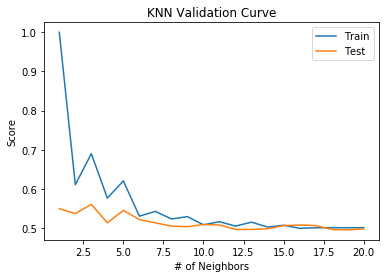

In [875]:
# How many neighbors?

## Create the classifier
knn = KNeighborsClassifier(n_neighbors = 10)

## Fit the data
knn.fit(Xcollege,ycollege)

depth_range = np.arange(1,21)
train_scores, test_scores = validation_curve(knn, Xcollege, ycollege, param_name='n_neighbors', 
                                             param_range=depth_range, cv=10,
                                            scoring = "balanced_accuracy")

### Compute the set of training and test means from the 
### accuracy scores.
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

### Plot the validation curve
pos_class = depth_range
fig1 = plt.figure()
plt.plot(pos_class, train_mean, label='Train')
plt.plot(pos_class, test_mean, label='Test')
plt.xlabel('# of Neighbors')
plt.ylabel('Score')
plt.title('KNN Validation Curve')
plt.legend()
plt.show()

In [856]:
#Enter score that maximized balanced accuracy
neighbors = 3

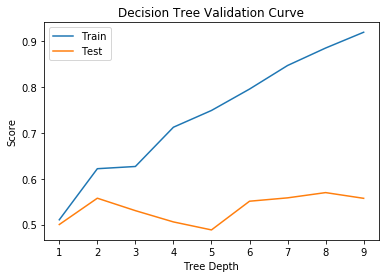

In [876]:
# Max tree depth?
dtree = tree.DecisionTreeClassifier()
dtree.fit(Xcollege, ycollege)

#tree depth ranging from 1 to 10
depth_range = np.arange(1,10)

train_scores, test_scores = validation_curve(model_2, Xcollege, ycollege, 
                                             param_name = "max_depth", param_range = depth_range, 
                                             scoring = "balanced_accuracy")

### Compute the set of training and test means from the 
### accuracy scores.
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

pos_class = depth_range
fig1 = plt.figure()
plt.plot(pos_class, train_mean, label='Train')
plt.plot(pos_class, test_mean, label='Test')
plt.xlabel('Tree Depth')
plt.ylabel('Score')
plt.title('Decision Tree Validation Curve')
plt.legend()
plt.show()

In [877]:
#Enter score that maximized balanced accuracy
tree_depth = 8

#### Generate a set of label predictions for *Private* using naive bayes, logistic regression, and KNN. Use the training data for fitting and the test data for predictions.

In [878]:
base_rate = sum(dta['test_optional'] == 1)/dta.shape[0]

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(Xcollege, ycollege)

## Decision Tree
#Fit new model with max depth of 5
dt = tree.DecisionTreeClassifier(max_depth = tree_depth)
dt.fit(X_train, y_train)
predictions_tree = dt.predict(X_test)

## Naive Bayes
nbg = GaussianNB(priors=[base_rate, (1-base_rate)])
nbg_fit = nbg.fit(X_train, y_train)
predictions_nb = nbg.predict(X_test)

## Logistic regression
logit = LogisticRegression(max_iter = 1000)
log_reg = logit.fit(X_train, y_train)
predictions_logit = logit.predict(X_test)

## KNN Classifier (6 neighbors)
knn = KNeighborsClassifier(n_neighbors = neighbors)
knn_fit = knn.fit(X_train, y_train)
predictions_knn = knn.predict(X_test)


prec_tree = precision_score(y_test, predictions_tree)
rec_tree = recall_score(y_test, predictions_tree)
f_tree = f1_score(y_test, predictions_tree)
acc_tree = accuracy_score(y_test, predictions_tree)
bacc_tree = balanced_accuracy_score(y_test, predictions_tree)



prec_nb = precision_score(y_test, predictions_nb)
rec_nb = recall_score(y_test, predictions_nb)
f_nb = f1_score(y_test, predictions_nb)
acc_nb = accuracy_score(y_test, predictions_nb)
bacc_nb = balanced_accuracy_score(y_test, predictions_nb)




prec_log = precision_score(y_test, predictions_logit)
rec_log = recall_score(y_test, predictions_logit)
f_log = f1_score(y_test, predictions_logit)
acc_log = accuracy_score(y_test, predictions_logit)
bacc_log = balanced_accuracy_score(y_test, predictions_logit)




prec_knn = precision_score(y_test, predictions_knn)
rec_knn = recall_score(y_test, predictions_knn)
f_knn = f1_score(y_test, predictions_knn)
acc_knn = accuracy_score(y_test, predictions_knn)
bacc_knn = balanced_accuracy_score(y_test, predictions_knn)



print("Decision Tree:")
print("Accuracy:", round(acc_tree,4))
print("Balanced accuracy:", round(bacc_tree,4))
print("Precision:", round(prec_tree,4))
print("Recall:", round(rec_tree,4))
print("F-measure:", round(f_tree,4))



print("\nNaive Bayes:")
print("Accuracy:", round(acc_nb,4))
print("Balanced accuracy:", round(bacc_nb,4))
print("Precision:", round(prec_nb,4))
print("Recall:", round(rec_nb,4))
print("F-measure:", round(f_nb,4))

print("\nLogit:")
print("Accuracy:", round(acc_log,4))
print("Balanced accuracy:", round(bacc_log,4))
print("Precision:", round(prec_log,4))
print("Recall:", round(rec_log,4))
print("F-measure:", round(f_log,4))

print("\nKNN:")
print("Accuracy:", round(acc_knn,4))
print("Balanced accuracy:", round(bacc_knn,4))
print("Precision:", round(prec_knn,4))
print("Recall:", round(rec_knn,4))
print("F-measure", round(f_knn,4))

preds = dt.predict(Xcollege)
dta_names["classified_dt"] = preds
false_positives_dt = dta_names[(dta_names.test_optional == 0) & (dta_names.classified_dt == 1)]

preds = nbg.predict(Xcollege)
dta_names["classified_nbg"] = preds
false_positives_nbg = dta_names[(dta_names.test_optional == 0) & (dta_names.classified_nbg == 1)]

preds = logit.predict(Xcollege)
dta_names["classified_logit"] = preds
false_positives_logit = dta_names[(dta_names.test_optional == 0) & (dta_names.classified_logit == 1)]

preds = knn.predict(Xcollege)
dta_names["classified_knn"] = preds
false_positives_knn = dta_names[(dta_names.test_optional == 0) & (dta_names.classified_knn == 1)]

Decision Tree:
Accuracy: 0.9192
Balanced accuracy: 0.4946
Precision: 0.0
Recall: 0.0
F-measure: 0.0

Naive Bayes:
Accuracy: 0.1414
Balanced accuracy: 0.538
Precision: 0.0761
Recall: 1.0
F-measure: 0.1414

Logit:
Accuracy: 0.899
Balanced accuracy: 0.4837
Precision: 0.0
Recall: 0.0
F-measure: 0.0

KNN:
Accuracy: 0.9293
Balanced accuracy: 0.5
Precision: 0.0
Recall: 0.0
F-measure 0.0


/Users/adamhearn/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Predict colleges which will be going test-optional

In [879]:
#subset of colleges that are falsely classified in decision tree and naive bayes
false_positives = dta_names[(dta_names.classified_logit == 1) 
                            #& (dta_names.classified_knn == 1)
                            #& (dta_names.classified_logit == 1)
                            & (dta_names.test_optional == 0)]
false_positives.name.tolist()

['Southern Connecticut State University',
 'University of Hawaii at Hilo',
 'Framingham State University',
 'Lincoln University']

* 'Albertus Magnus College',
* 'University of Bridgeport',
* 'University of New Haven',
* 'Quinnipiac University',
* 'Flagler College-St Augustine',
 'Illinois Wesleyan University',
* 'DePauw University',
* 'Centre College',
* 'Colby College',
* 'University of New England',
 'McDaniel College',
* 'Amherst College',
* 'Babson College',
 'Becker College',
 'Bentley University',
* 'Brandeis University',
 'Curry College',
 'Gordon College',
 'Lasell College',
* 'College of Our Lady of the Elms',
* 'Springfield College',
* 'Wentworth Institute of Technology',
* 'Hamilton College',
 'Iona College',
 'Manhattan College',
 'DeSales University',
* 'Bucknell University',
 'Elizabethtown College',
 'La Roche College',
 'Messiah College',
* 'Moravian College',
 'University of the Sciences',
 'University of Scranton',
 'Erskine College',
* 'Rhodes College',
* 'Middlebury College',
 'Randolph College',
* 'University of Richmond',
* 'Roanoke College'